## (1) Load model

In [12]:
from model import Mamba, ModelArgs
from transformers import AutoTokenizer

# One of:
#     'state-spaces/mamba-2.8b-slimpj'
#     'state-spaces/mamba-2.8b'
#     'state-spaces/mamba-1.4b'
#     'state-spaces/mamba-790m'
#     'state-spaces/mamba-370m'
#     'state-spaces/mamba-130m'
pretrained_model_name = 'state-spaces/mamba-370m'

model = Mamba.from_pretrained(pretrained_model_name)
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b')

## (2) Generate Text

In [3]:
import torch
import torch.nn.functional as F


def generate(model,
             tokenizer,
             prompt: str,
             n_tokens_to_gen: int = 50,
             sample: bool = True,
             top_k: int = 40):
    model.eval()
    
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids
    
    for token_n in range(n_tokens_to_gen):
        with torch.no_grad():
            indices_to_input = input_ids
            next_token_logits = model(indices_to_input)[:, -1]
        
        probs = F.softmax(next_token_logits, dim=-1)
        (batch, vocab_size) = probs.shape
        
        if top_k is not None:
            (values, indices) = torch.topk(probs, k=top_k)
            probs[probs < values[:, -1, None]] = 0
            probs = probs / probs.sum(axis=1, keepdims=True)
        
        if sample:
            next_indices = torch.multinomial(probs, num_samples=1)
        else:
            next_indices = torch.argmax(probs, dim=-1)[:, None]
        
        input_ids = torch.cat([input_ids, next_indices], dim=1)

    output_completions = [tokenizer.decode(output.tolist()) for output in input_ids][0]
    
    return output_completions

In [10]:
print(generate(model, tokenizer, 'Mamba is the'))

Mamba is the world's longest venomous snake with an estimated length of over 150 m. With such a large size and a venomous bite, Mamba kills by stabbing the victim (which is more painful and less effective than a single stab of the bite)


In [9]:
print(generate(model, tokenizer, 'John: Hi!\nSally:'))

John: Hi!
Sally: Hey!
John: So, when's the wedding?
Sally: We haven't decided.
John: It's in September.
Sally: Yeah, we were thinking July or
August.
John: I'm not too


In [8]:
print(generate(model, tokenizer, 'The meaning of life is '))

The meaning of life is 
just this: It is the best you can do.

--K.J.

And finally: How to handle your emotions. 

<|endoftext|>Q:

Error creating an EntityManager instance in JavaEE 7

This is


In [11]:
print(generate(model, tokenizer, 'def reverse_string('))

def reverse_string(text, result):
        # find the position of the start of the string.
        start = text.index(text[0:-1])
        # find the position where the string begins changing.
        end = text.index


# mamba
## 获取数据

In [2]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open     High       Low     Close    Volume
Date                                                       
2018-01-02   52.6510   53.799   52.6510   53.6720  31753540
2018-01-03   53.6965   54.805   53.6715   54.5760  31305800
2018-01-04   54.8545   55.204   54.7130   54.8000  26049960
2018-01-05   55.1725   55.679   55.0900   55.5145  30238600
2018-01-08   55.5500   55.958   55.5000   55.7105  24626920
...              ...      ...       ...       ...       ...
2023-12-22  140.7700  141.990  140.7100  141.4900  26532199
2023-12-26  141.5900  142.680  141.1900  141.5200  16780333
2023-12-27  141.5900  142.080  139.8860  140.3700  19628618
2023-12-28  140.7800  141.140  139.7500  140.2300  16045712
2023-12-29  139.6300  140.360  138.7800  139.6900  18733017

[1509 rows x 5 columns]


In [3]:
mem_his_days=5
per_days=10

# 股票数据
df['label'] = df['Close'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,1:-1])

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print(len(X_lately))

(1495, 5, 4)
(1495,)
10


## 制作数据集

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_lately))

(1345, 5, 4)
(1345,)
(150, 5, 4)
(150,)
10


## 建立模型

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split

# 训练数据
batch, length, dim = 64, 5, 4
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

# 定义模型

class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model = SequenceModel(input_dim=dim, model_dim=16, state_dim=16, conv_width=4, expand_factor=2, output_dim=1)
print(model)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



SequenceModel(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)
Epoch [5/50], Loss: 14794.2568
Epoch [10/50], Loss: 13720.4785
Epoch [15/50], Loss: 7368.4814
Epoch [20/50], Loss: 3911.2712
Epoch [25/50], Loss: 3420.4663
Epoch [30/50], Loss: 5346.4155
Epoch [35/50], Loss: 4215.1064
Epoch [40/50], Loss: 3330.8542
Epoch [45/50], Loss: 26.3801
Epoch [50/50], Loss: 908.8738


In [14]:
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

print(f"Predicted shape: {y_pred.shape}")
# 计算MAPE
y_pred = y_pred.to('cpu').numpy()
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f'MAPE on test set: {mape:.4f}')


Predicted shape: torch.Size([150, 1])
MAPE on test set: 54.1307


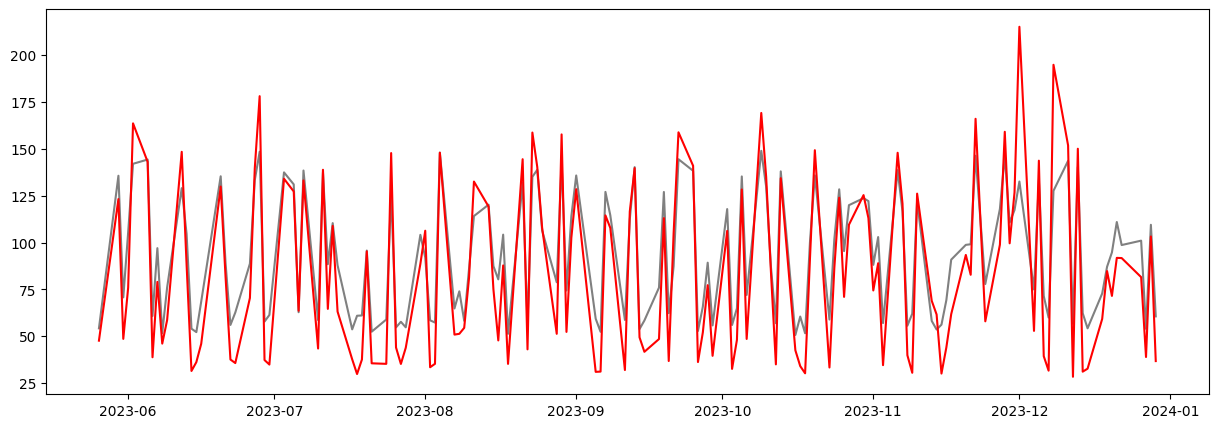

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

In [ ]:
# 计算残差
y_e = y_pred[:,0]-y_test
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_e,color='gray',label='price')
plt.show()

In [ ]:
# 对残差纯随机性检验
import numpy as np
import statsmodels.api as sm

data = y_e
# 进行 LBQ 检验，设置 lags 参数为需要检验的自相关阶数
lags = 10  # 选择检验的最大自相关阶数
lbq_test = sm.stats.acorr_ljungbox(data, lags=lags)
print(lbq_test)

# lb_stat 越小，残差自相关性越弱
# p 大于 0.05 才支持 纯随机 假设

In [10]:
from model import Mamba, ModelArgs,MambaBlock
import torch
# batch, length, dim = 2, 64, 4
# x = torch.randn(batch, length, dim)
args = ModelArgs(d_model=4,n_layer=16,d_conv=4,vocab_size=16)
model = MambaBlock(args)
y_train_tensor = model(X_train_tensor)
# assert y.shape == x.shape

In [6]:
print(X_train.shape)

(1345, 5, 4)
